In [10]:
#!pip install aquacrop==2.2
#!pip install numba==0.55
#!pip install statsmodels==0.13.2
#!pip install SALib
#!pip install -U scikit-learn scipy matplotlib
!pip install --upgrade pyswarm  #https://pythonhosted.org/pyswarm/

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4479 sha256=56c523bd99379ee1b9f2645b92cde5c277aaa7c78bc196862421fb3e483c5b5c
  Stored in directory: /home/jupyter-wndlovu/.cache/pip/wheels/ff/d2/b7/80118e5698de2bd0b8d1b3397abf7fdfc45c15ffc454b52145
Successfully built pyswarm


In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from aquacrop.utils import prepare_weather, get_filepath
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, IrrigationManagement
#from aquacrop.entities import IrrigationManagement
from os import chdir, getcwd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import pickle 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
from pyswarm import pso
wd=getcwd() # set working directory
chdir(wd)

In [2]:
# read in input data 
# corn yield
ks_corn = pd.read_csv('/home/jupyter-wndlovu/eggs/calib/CornYield_GMD4_WNdlovu_v1_20230117.csv')
ks_irrig = pd.read_csv('/home/jupyter-wndlovu/eggs/calib/IrrigationDepth_GMD4_WNdlovu_v1_20230123.csv')

# meteorological
with open('/home/jupyter-wndlovu/eggs/calib/ks_gridMET.pickle', 'rb') as met: 
    gridMET_county = pickle.load(met)
   
    
with open('/home/jupyter-wndlovu/eggs/calib/ks_ccm.pickle', 'rb') as info: 
    grouped_info = pickle.load(info)   
    
# soils
#with open('/home/jupyter-wndlovu/eggs/calib/ks_soil.pickle', 'rb') as sl: 
    #soil_data = pickle.load(sl) 
    
soil_data = pd.read_pickle('/home/jupyter-wndlovu/eggs/calib/ks_soil.pickle')

In [3]:
# sheridan irrigated corn
sher_irrig_corn = ks_corn[(ks_corn['County'] == 'SHERIDAN') & (ks_corn['Irrig_status'] == 'irrigated')]
sher_irrig_corn = sher_irrig_corn[['Year', 'Value']] 

sher_wimas = ks_irrig[(ks_irrig['county_abrev'] == 'SD') & (ks_irrig['crop_name'] == 'Corn') & (ks_irrig['WUA_YEAR'].between(2000, 2014))]

# calculate county median irrigation # better method??
sher_wimas = sher_wimas.groupby(['WUA_YEAR']).agg({'irrig_depth': lambda x: x.median(skipna=True)})
sher_wimas = sher_wimas.reset_index()
sher_wimas = sher_wimas.rename(columns={
                   'WUA_YEAR': 'Year'
                   })

In [4]:
custom_soil = []
for soil_df in soil_data:
   for i, row in soil_df.iterrows():   #soil_df.itertuples():
        ids = soil_df['UID'][i] #create soil_df with UID from the soils file used - fix this
        #id_list.append(ids)
        if row['depth_cm'] == "0-5":
            pred_thWP_5 = ((-0.024*((soil_df['sand_prc'][i])/100))) + ((0.487*((soil_df['clay_prc'][i])/100))) + ((0.006*((soil_df['om'][i])/100))) + ((0.005*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.013*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.068*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.031
            wp_5 = pred_thWP_5 + (0.14 * pred_thWP_5) - 0.02
            pred_thFC_5 = ((-0.251*((soil_df['sand_prc'][i])/100))) + ((0.195*((soil_df['clay_prc'][i])/100)))+ ((0.011*((soil_df['om'][i])/100))) + ((0.006*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.027*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.452*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.299
            fc_5 = pred_thFC_5 + (1.283 * (np.power(pred_thFC_5, 2))) - (0.374 * pred_thFC_5) - 0.015
            #fc = pred_thFC + (1.283 * (pred_thFC*pred_thFC)) - (0.374 * pred_thFC) - 0.015
            ts_5 =soil_df["thetaS_m3m3"][i]
            ks_5=(soil_df['Ksat_cmHr'][i])*240
        if row['depth_cm'] == "5-15":
            pred_thWP_15 = ((-0.024*((soil_df['sand_prc'][i])/100))) + ((0.487*((soil_df['clay_prc'][i])/100))) + ((0.006*((soil_df['om'][i])/100))) + ((0.005*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.013*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.068*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.031
            wp_15 = pred_thWP_15 + (0.14 * pred_thWP_15) - 0.02
            pred_thFC_15 = ((-0.251*((soil_df['sand_prc'][i])/100))) + ((0.195*((soil_df['clay_prc'][i])/100)))+ ((0.011*((soil_df['om'][i])/100))) + ((0.006*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.027*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.452*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.299
            fc_15 = pred_thFC_15 + (1.283 * (np.power(pred_thFC_15, 2))) - (0.374 * pred_thFC_15) - 0.015
            #fc = pred_thFC + (1.283 * (pred_thFC*pred_thFC)) - (0.374 * pred_thFC) - 0.015
            ts_15 =soil_df["thetaS_m3m3"][i]
            ks_15=(soil_df['Ksat_cmHr'][i])*240
        if row['depth_cm'] == "15-30":
            pred_thWP_30 = ((-0.024*((soil_df['sand_prc'][i])/100))) + ((0.487*((soil_df['clay_prc'][i])/100))) + ((0.006*((soil_df['om'][i])/100))) + ((0.005*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.013*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.068*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.031
            wp_30 = pred_thWP_30 + (0.14 * pred_thWP_30) - 0.02
            pred_thFC_30 = ((-0.251*((soil_df['sand_prc'][i])/100))) + ((0.195*((soil_df['clay_prc'][i])/100)))+ ((0.011*((soil_df['om'][i])/100))) + ((0.006*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.027*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.452*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.299
            fc_30 = pred_thFC_30 + (1.283 * (np.power(pred_thFC_30, 2))) - (0.374 * pred_thFC_30) - 0.015
            #fc = pred_thFC + (1.283 * (pred_thFC*pred_thFC)) - (0.374 * pred_thFC) - 0.015
            ts_30 =soil_df["thetaS_m3m3"][i]
            ks_30=(soil_df['Ksat_cmHr'][i])*240
        if row['depth_cm'] == "30-60":
            pred_thWP_60 = ((-0.024*((soil_df['sand_prc'][i])/100))) + ((0.487*((soil_df['clay_prc'][i])/100))) + ((0.006*((soil_df['om'][i])/100))) + ((0.005*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.013*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.068*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.031
            wp_60 = pred_thWP_60 + (0.14 * pred_thWP_60) - 0.02
            pred_thFC_60 = ((-0.251*((soil_df['sand_prc'][i])/100))) + ((0.195*((soil_df['clay_prc'][i])/100)))+ ((0.011*((soil_df['om'][i])/100))) + ((0.006*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.027*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.452*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.299
            fc_60 = pred_thFC_60 + (1.283 * (np.power(pred_thFC_60, 2))) - (0.374 * pred_thFC_60) - 0.015
            #fc = pred_thFC + (1.283 * (pred_thFC*pred_thFC)) - (0.374 * pred_thFC) - 0.015
            ts_60 =soil_df["thetaS_m3m3"][i]
            ks_60=(soil_df['Ksat_cmHr'][i])*240
        if row['depth_cm'] == "60-100":
            pred_thWP_100 = ((-0.024*((soil_df['sand_prc'][i])/100))) + ((0.487*((soil_df['clay_prc'][i])/100))) + ((0.006*((soil_df['om'][i])/100))) + ((0.005*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.013*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.068*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.031
            wp_100 = pred_thWP_100 + (0.14 * pred_thWP_100) - 0.02
            pred_thFC_100 = ((-0.251*((soil_df['sand_prc'][i])/100))) + ((0.195*((soil_df['clay_prc'][i])/100)))+ ((0.011*((soil_df['om'][i])/100))) + ((0.006*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.027*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.452*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.299
            fc_100 = pred_thFC_100 + (1.283 * (np.power(pred_thFC_100, 2))) - (0.374 * pred_thFC_100) - 0.015
            #fc = pred_thFC + (1.283 * (pred_thFC*pred_thFC)) - (0.374 * pred_thFC) - 0.015
            ts_100 =soil_df["thetaS_m3m3"][i]
            ks_100=(soil_df['Ksat_cmHr'][i])*240
        if row['depth_cm'] == "100-200":
            pred_thWP_200 = ((-0.024*((soil_df['sand_prc'][i])/100))) + ((0.487*((soil_df['clay_prc'][i])/100))) + ((0.006*((soil_df['om'][i])/100))) + ((0.005*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.013*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.068*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.031
            wp_200 = pred_thWP_200 + (0.14 * pred_thWP_200) - 0.02
            pred_thFC_200 = ((-0.251*((soil_df['sand_prc'][i])/100))) + ((0.195*((soil_df['clay_prc'][i])/100)))+ ((0.011*((soil_df['om'][i])/100))) + ((0.006*((soil_df['sand_prc'][i])/100))*((soil_df['om'][i])/100))- ((0.027*((soil_df['clay_prc'][i])/100))*((soil_df['om'][i])/100))+ ((0.452*((soil_df['sand_prc'][i])/100))*((soil_df['clay_prc'][i])/100))+ 0.299
            fc_200 = pred_thFC_200 + (1.283 * (np.power(pred_thFC_200, 2))) - (0.374 * pred_thFC_200) - 0.015
            #fc = pred_thFC + (1.283 * (pred_thFC*pred_thFC)) - (0.374 * pred_thFC) - 0.015
            ts_200 =soil_df["thetaS_m3m3"][i]
            ks_200=(soil_df['Ksat_cmHr'][i])*240
        

            # create soil compartments
            custom = Soil('custom',cn=46,rew=7, dz=[0.025]*2+[0.05]*2+[0.075]*2+[0.15]*2+[0.2]*2+[0.5]*2)

            custom.add_layer(thickness=0.05,thS=ts_5, # assuming soil properties are the same in the upper 0.1m
                 Ksat=ks_5,thWP =wp_5 , 
                 thFC = fc_5, penetrability = 100.0)
            custom.add_layer(thickness=0.15,thS=ts_15, # assuming soil properties are the same in the upper 0.1m
                         Ksat=ks_15,thWP =wp_15 , 
                         thFC = fc_15, penetrability = 100.0)
            custom.add_layer(thickness=0.3,thS=ts_30, # assuming soil properties are the same in the upper 0.1m
                         Ksat=ks_30,thWP =wp_30 , 
                         thFC = fc_30, penetrability = 100.0)
            custom.add_layer(thickness=0.3,thS=ts_60, # assuming soil properties are the same in the upper 0.1m
                         Ksat=ks_60,thWP =wp_60 , 
                         thFC = fc_60, penetrability = 100.0)
            custom.add_layer(thickness=0.4,thS=ts_100, # assuming soil properties are the same in the upper 0.1m
                         Ksat=ks_100,thWP =wp_100 , 
                         thFC = fc_100, penetrability = 100.0)
            custom.add_layer(thickness=1,thS=ts_200, # assuming soil properties are the same in the upper 0.1m
                         Ksat=ks_200,thWP =wp_200 , 
                         thFC = fc_200, penetrability = 100.0)
            custom_soil.append(custom)



In [5]:
# sheridan gridMET 
sher_gridMET = gridMET_county[10]
sher_gridMET = sher_gridMET.assign(year = sher_gridMET['Date'].dt.year) # create year variable
#sher_gridMET = sher_gridMET[sher_gridMET['year'] == 2012] # filter for 2012
sher_gridMET = sher_gridMET.drop(['year'], axis=1) # drop year variable
wdf = sher_gridMET

#wdf['MinTemp'].min()

# sheridan soils
sher_soils = custom_soil[10]
custom = sher_soils

In [6]:
sim_start = '2000/01/01' #dates to match crop data
sim_end = '2020/12/31'
initWC = InitialWaterContent(value=['FC'])
irr_mngt = IrrigationManagement(irrigation_method=1,SMT=[80]*4) # no irrigation


In [7]:
# uncalibrated model - yield
crop_uncalibrated = Crop('Maize', planting_date='05/01') 

# run model
model_uc = AquaCropModel(sim_start,sim_end,wdf,custom,crop_uncalibrated,initWC, irr_mngt)
model_uc.run_model(till_termination=True) # run model till the end
#model_uc_et = model_uc._outputs.water_flux
model_uc_irr = model_uc._outputs.final_stats
#model_df_water_storage = model._outputs.water_storage
#model_df_crp_grwth = model._outputs.crop_growth

## Create year variable
model_uc_irr = model_uc_irr.assign(Year =  model_uc_irr['Harvest Date (YYYY/MM/DD)'].dt.year)
model_uc_irr = model_uc_irr.rename(columns={
                   'Yield (tonne/ha)': 'Uncalib Yield (t/ha)',
                   'Seasonal irrigation (mm)': 'Uncalib Irrigation (mm)'
                   })
model_uc_irr = model_uc_irr[['Year', 'Uncalib Yield (t/ha)', 'Uncalib Irrigation (mm)']]

In [8]:
####### pyswarm calibration
import statistics as stats

def objFun(x):
    
    wpy, ccx, wp, kc, smt, rtm, kcdcl, hi = x
    
    irr_mngt = IrrigationManagement(irrigation_method=1,SMT=[smt]*4) 
    
    crop_calibrated = Crop("Maize", planting_date='05/01',
                # growth stages
                CalendarType = 1,
                SwitchGDD = 1,  #Convert calendar to gdd mode if inputs are given in calendar days (0 = No; 1 = Yes)
                ##Crop Development
                Emergence = 15, #15
                Senescence = 42, #42
                Maturity = 131, #131
                MaxRooting = 91, #91
                HIstart = 83,
                Flowering = 67,
                YldForm = 60,
                Zmin = rtm,
                
                # canopy cover profile
                CCx = ccx,
                CGC = 13.7,
                CDC = 1.31,
                
                
                WPy = wpy,
                Kcb = kc,
                fage = kcdcl,         
                WP = wp,  
                HI0 = hi
        )


    # run model
    model_c = AquaCropModel(sim_start,sim_end,wdf,custom,crop_calibrated,initWC, irr_mngt)
    model_c.run_model(till_termination=True) # run model till the end
    model_c_et = model_c._outputs.water_flux
    model_c_irr = model_c._outputs.final_stats
    #model_c_water_storage = model_c._outputs.water_storage
    #model_c_crp_grwth = model_c._outputs.crop_growth

     # make year a column 
    model_c_irr = model_c_irr.assign(Year =  model_c_irr['Harvest Date (YYYY/MM/DD)'].dt.year)
    model_c_irr = model_c_irr.rename(columns={
                       'Yield (tonne/ha)': 'Calib Yield (t/ha)',
                       'Seasonal irrigation (mm)': 'Calib Irrigation (mm)'
                       })

    model_c_irr = model_c_irr[['Year', 'Calib Yield (t/ha)', 'Calib Irrigation (mm)']]

    #return model_c_irr

    # compare models
    model_comp = model_c_irr.merge(sher_irrig_corn,on='Year').merge(sher_wimas, on = 'Year')
    model_comp = model_comp.assign(YieldUSDA = model_comp['Value']*0.0673)
    
   # return(model_comp)
    
    y_yield = model_comp[['YieldUSDA']]
    yhat_yield = model_comp[['Calib Yield (t/ha)']]
    
    y_irrig = model_comp[['irrig_depth']]
    yhat_irrig = model_comp[['Calib Irrigation (mm)']]
    
    #print(y)
    #return(yhat)
    
    var_yield = y_yield.var()
    var_irrig = y_irrig.var()
    
    #return var_yield, var_irrig
    #fitness = ((y[['YieldUSDA']]-yhat[['Calib Yield (t/ha)']])**2).sum() # Calculate fitness score based on AquaCrop performance
    #fitness = (((np.array(y_yield)-np.array(yhat_yield))**2)*(1/var_yield)).sum() #+ (var_irrig*((np.array(y_irrig)-np.array(yhat_irrig))**2)).sum().item()
    fitness = (((np.array(y_yield)-np.array(yhat_yield))**2)*np.array(1/var_yield)).sum().item() +(((np.array(y_irrig)-np.array(yhat_irrig))**2)*np.array(1/var_irrig)).sum().item()
    return fitness # fitness 
#.sum().item()


In [9]:
import statistics as stats

def objFun(x):
    
    wpy, ccx, wp, kc, smt, rtm, kcdcl, hi = x
    
    irr_mngt = IrrigationManagement(irrigation_method=1,SMT=[smt]*4) 
    
    crop_calibrated = Crop("Maize", planting_date='05/01',
                # growth stages
                CalendarType = 1,
                SwitchGDD = 1,  #Convert calendar to gdd mode if inputs are given in calendar days (0 = No; 1 = Yes)
                ##Crop Development
                Emergence = 15, #15
                Senescence = 42, #42
                Maturity = 131, #131
                MaxRooting = 91, #91
                HIstart = 83,
                Flowering = 67,
                YldForm = 60,
                Zmin = rtm,
                
                # canopy cover profile
                CCx = ccx,
                CGC = 13.7,
                CDC = 1.31,
                
                
                WPy = wpy,
                Kcb = kc,
                fage = kcdcl,         
                WP = wp,  
                HI0 = hi
        )


    # run model
    model_c = AquaCropModel(sim_start,sim_end,wdf,custom,crop_calibrated,initWC, irr_mngt)
    model_c.run_model(till_termination=True) # run model till the end
    model_c_et = model_c._outputs.water_flux
    model_c_irr = model_c._outputs.final_stats
    #model_c_water_storage = model_c._outputs.water_storage
    #model_c_crp_grwth = model_c._outputs.crop_growth

     # make year a column 
    model_c_irr = model_c_irr.assign(Year =  model_c_irr['Harvest Date (YYYY/MM/DD)'].dt.year)
    model_c_irr = model_c_irr.rename(columns={
                       'Yield (tonne/ha)': 'Calib Yield (t/ha)',
                       'Seasonal irrigation (mm)': 'Calib Irrigation (mm)'
                       })

    model_c_irr = model_c_irr[['Year', 'Calib Yield (t/ha)', 'Calib Irrigation (mm)']]

    #return model_c_irr

    
    
    # compare models
    model_comp = model_c_irr.merge(sher_irrig_corn,on='Year').merge(sher_wimas, on = 'Year')
    model_comp = model_comp.assign(YieldUSDA = model_comp['Value']*0.0673)
    
    
    model_comp = model_comp[model_comp['Year'].isin([2006, 2007, 2009, 2010, 2012, 2014])]
   # return(model_comp)
    
    y_yield = model_comp[['YieldUSDA']]
    yhat_yield = model_comp[['Calib Yield (t/ha)']]
    
    y_irrig = model_comp[['irrig_depth']]
    yhat_irrig = model_comp[['Calib Irrigation (mm)']]
    
    #print(y)
    #return(yhat)
    
    var_yield = y_yield.var()
    var_irrig = y_irrig.var()
    
    #return var_yield, var_irrig
    #fitness = ((y[['YieldUSDA']]-yhat[['Calib Yield (t/ha)']])**2).sum() # Calculate fitness score based on AquaCrop performance
    #fitness = (((np.array(y_yield)-np.array(yhat_yield))**2)*(1/var_yield)).sum() #+ (var_irrig*((np.array(y_irrig)-np.array(yhat_irrig))**2)).sum().item()
    fitness = (((np.array(y_yield)-np.array(yhat_yield))**2)*np.array(1/var_yield)).sum().item() +(((np.array(y_irrig)-np.array(yhat_irrig))**2)*np.array(1/var_irrig)).sum().item()
    
    print(model_comp)
    print(fitness)
    
    return fitness # fitness 
#.sum().item()


In [16]:
import statistics as stats

def objFun(x):
    
    wpy, ccx, wp, kc, smt, rtm, kcdcl, hi = x
    
    irr_mngt = IrrigationManagement(irrigation_method=1,SMT=[smt]*4) 
    
    crop_calibrated = Crop("Maize", planting_date='05/01',
                # growth stages
                CalendarType = 1,
                SwitchGDD = 1,  #Convert calendar to gdd mode if inputs are given in calendar days (0 = No; 1 = Yes)
                ##Crop Development
                Emergence = 15, #15
                Senescence = 42, #42
                Maturity = 131, #131
                MaxRooting = 91, #91
                HIstart = 83,
                Flowering = 67,
                YldForm = 60,
                Zmin = rtm,
                
                # canopy cover profile
                CCx = ccx,
                CGC = 13.7,
                CDC = 1.31,
                
                
                WPy = wpy,
                Kcb = kc,
                fage = kcdcl,         
                WP = wp,  
                HI0 = hi
        )


    # run model
    model_c = AquaCropModel(sim_start,sim_end,wdf,custom,crop_calibrated,initWC, irr_mngt)
    model_c.run_model(till_termination=True) # run model till the end
    model_c_et = model_c._outputs.water_flux
    model_c_irr = model_c._outputs.final_stats
    #model_c_water_storage = model_c._outputs.water_storage
    #model_c_crp_grwth = model_c._outputs.crop_growth

     # make year a column 
    model_c_irr = model_c_irr.assign(Year =  model_c_irr['Harvest Date (YYYY/MM/DD)'].dt.year)
    model_c_irr = model_c_irr.rename(columns={
                       'Yield (tonne/ha)': 'Calib Yield (t/ha)',
                       'Seasonal irrigation (mm)': 'Calib Irrigation (mm)'
                       })

    model_c_irr = model_c_irr[['Year', 'Calib Yield (t/ha)', 'Calib Irrigation (mm)']]

    #return model_c_irr

    
    
    # compare models
    model_comp = model_c_irr.merge(sher_irrig_corn,on='Year').merge(sher_wimas, on = 'Year')
    model_comp = model_comp.assign(YieldUSDA = model_comp['Value']*0.0673)


    model_comp = model_comp[model_comp['Year'].isin([2006, 2007, 2009, 2010, 2012, 2014])]
       # return(model_comp)

    y_yield = model_comp[['YieldUSDA']]
    yhat_yield = model_comp[['Calib Yield (t/ha)']]

    y_irrig = model_comp[['irrig_depth']]
    yhat_irrig = model_comp[['Calib Irrigation (mm)']]

        #print(y)
        #return(yhat)

    var_yield = y_yield.var()
    var_irrig = y_irrig.var()

        #return var_yield, var_irrig
        #fitness = ((y[['YieldUSDA']]-yhat[['Calib Yield (t/ha)']])**2).sum() # Calculate fitness score based on AquaCrop performance
        #fitness = (((np.array(y_yield)-np.array(yhat_yield))**2)*(1/var_yield)).sum() #+ (var_irrig*((np.array(y_irrig)-np.array(yhat_irrig))**2)).sum().item()
    fitness = (((np.array(y_yield)-np.array(yhat_yield))**2)*np.array(1/var_yield)).sum().item() +(((np.array(y_irrig)-np.array(yhat_irrig))**2)*np.array(1/var_irrig)).sum().item()

    print(model_comp)
    print(fitness)

    return fitness # fitness 
    #.sum().item()
    #else:
        #print('nah')


In [301]:
#wpy, ccx, wp, kc, smt, rtm, kcdcl, hi

#'ccx', 'kc', 'wp', 'wpy', 'hi', 'kcdcl', 'rtm', 'smt'
#[0.650, 1.0, 30.0, 75.0, 0.48, 0.1, 0.2, 45.0]
gg = objFun([75.0, 0.65, 30.00, 1.0, 45.00, 0.2, 0.1, 0.48])
gg

,Year,Calib Yield (t/ha),Calib Irrigation (mm),Value,irrig_depth,YieldUSDA
6,2006,8.876300,600.586542,155.0,358.140000,10.43150
7,2007,8.737158,572.914556,206.0,365.760000,13.86380
8,2009,9.617276,412.310979,211.0,264.160000,14.20030
9,2010,8.863335,639.328743,185.2,330.991735,12.46396
10,2012,7.661879,788.676576,179.5,421.178182,12.08035
11,2014,9.461974,551.442600,194.0,310.618909,13.05620


In [10]:
lb = [75.000, 0.650, 30.00, 1.00, 45.00, 0.20, 0.100]
ub = [125.00, 0.990, 35.00, 1.10, 90.00, 0.30, 0.500]

In [ ]:
lb = [75.000, 0.650, 30.00, 1.00, 45.00, 0.20, 0.100]
y = []
for i in lb:
    x = (10*5)[i]
    y.append(x)

In [18]:

# upper and lower bounds for wpy, ccx, wp, kc, smt, rtm, kcdcl
lb = [0.650, 1.0, 30.0, 75.0, 0.48, 0.1, 0.2, 45.0]
ub = [0.99, 1.10, 35.00, 125.0, 0.52, 0.5, 0.3, 90.0]

xopt, fopt = pso(objFun, lb, ub)


#objFun([75.000, 0.650])

    Year  Calib Yield (t/ha)  Calib Irrigation (mm)  Value  irrig_depth  \
6   2006         1273.906156                 2825.0  155.0   358.140000   
7   2007         1690.029298                 2825.0  206.0   365.760000   
8   2009         2204.949624                 3075.0  211.0   264.160000   
9   2010         1338.929647                 2800.0  185.2   330.991735   
10  2012         1212.593498                 2750.0  179.5   421.178182   
11  2014         1688.940928                 2925.0  194.0   310.618909   

    YieldUSDA  
6    10.43150  
7    13.86380  
8    14.20030  
9    12.46396  
10   12.08035  
11   13.05620  
8179151.748676473
    Year  Calib Yield (t/ha)  Calib Irrigation (mm)  Value  irrig_depth  \
6   2006         1571.996606                 2850.0  155.0   358.140000   
7   2007         1860.879252                 2875.0  206.0   365.760000   
8   2009         2361.136765                 3075.0  211.0   264.160000   
9   2010         1540.150950                

KeyboardInterrupt: 

In [ ]:
# array([112.88608106,   0.70888526,  32.6665472 ,   1.02556756,
        #75.00778691,   0.21639639,   0.14348092])

In [84]:
xopt

array([122.77917946,   0.99      ,  30.46071438,   1.00468942,
        45.        ,   0.2       ,   0.5       ])

In [30]:
xopt

array([115.91941572,   0.98100162,  31.57797746,   1.00000038,
        55.04316206,   0.21158912,   0.5       ])

In [28]:
xopt

array([125.        ,   0.99      ,  30.28673258,   1.        ,
        45.        ,   0.29850293,   0.49967905])

In [111]:
xopt

array([122.77917946,   0.99      ,  30.46071438,   1.00468942,
        45.        ,   0.2       ,   0.5       ])

In [271]:
# calibrated model - yield
irr_mngt_man = IrrigationManagement(irrigation_method=1, SMT=[80]*4) #55.04316206

crop_calibrated_man = Crop("Maize", planting_date='05/01',
            # growth stages
            CalendarType = 1,
            SwitchGDD = 1,  #Convert calendar to gdd mode if inputs are given in calendar days (0 = No; 1 = Yes)
            ##Crop Development
            Emergence = 15, #15
            Senescence = 42, #42
            Maturity = 131, #131
            MaxRooting = 91, #91
            HIstart = 83,
            Flowering = 67,
            YldForm = 60,
            
            
            # canopy cover profile
            #CCx = 0.94,
            CGC = 13.7,
            CDC = 1.31


            
    )


# run model
model_c_man = AquaCropModel('2000/05/01','2020/12/30',wdf,custom,crop_calibrated_man,initWC, irr_mngt_man)
model_c_man.run_model(till_termination=True) # run model till the end
#model_c_et = model_c._outputs.water_flux
model_c_irr_man = model_c_man._outputs.final_stats
#model_c_water_storage = model_c._outputs.water_storage
model_c_crp_grwth = model_c._outputs.crop_growth

 # make year a column 
model_c_irr_man = model_c_irr_man.assign(Year =  model_c_irr_man['Harvest Date (YYYY/MM/DD)'].dt.year)
model_c_irr_man = model_c_irr_man.rename(columns={
                   'Yield (tonne/ha)': 'Manual Calib Yield (t/ha)',
                   'Seasonal irrigation (mm)': 'Manual Calib Irrigation (mm)'
                   })

#model_c_irr = model_c_irr[['Year', 'Calib Yield (t/ha)', 'Calib Irrigation (mm)']]
model_c_irr_man


,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Manual Calib Yield (t/ha),Manual Calib Irrigation (mm),Year
0,0,Maize,2000-09-11,132,13.433104,753.931937,2000
1,1,Maize,2001-09-14,500,13.440112,678.927020,2001
2,2,Maize,2002-09-11,862,12.781477,821.085278,2002
3,3,Maize,2003-09-21,1237,13.417065,675.113467,2003
4,4,Maize,2004-09-23,1605,14.869781,693.488589,2004
5,5,Maize,2005-09-15,1962,13.962938,664.282821,2005
6,6,Maize,2006-09-14,2326,13.356732,666.253478,2006
7,7,Maize,2007-09-09,2686,13.429842,672.675057,2007
8,8,Maize,2008-09-27,3070,14.529934,681.723787,2008
9,9,Maize,2009-10-06,3444,14.816974,528.212245,2009


In [250]:
#model_c_crp_grwth.sample(n = 20)

,time_step_counter,season_counter,dap,gdd,gdd_cum,z_root,canopy_cover,canopy_cover_ns,biomass,biomass_ns,harvest_index,harvest_index_adj,yield_
6877,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2632,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5752,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4370,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
153,153.0,0.0,24.0,8.856344,246.457894,0.254374,0.060510,0.060510,20.203358,20.238781,0.000000,0.000000,0.00000
7264,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5074,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4862,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3829,3829.0,10.0,48.0,16.457458,543.135038,0.295934,0.673168,0.673168,394.178025,394.381367,0.000000,0.000000,0.00000
1364,1364.0,3.0,140.0,12.105925,1797.093355,0.297140,0.456127,0.456127,2764.088932,2776.934752,0.471859,0.471934,13.04468


In [272]:
# calibrated model - yield
irr_mngt = IrrigationManagement(irrigation_method=1, SMT=[75]*4) #55.04316206

crop_calibrated = Crop("Maize", planting_date='05/01',
            # growth stages
            CalendarType = 1,
            SwitchGDD = 1,  #Convert calendar to gdd mode if inputs are given in calendar days (0 = No; 1 = Yes)
            ##Crop Development
            Emergence = 15, #15
            Senescence = 42, #42
            Maturity = 131, #131
            MaxRooting = 91, #91
            HIstart = 83,
            Flowering = 67,
            YldForm = 60,
            
            
            # canopy cover profile
            #CCx = 0.94,
            CGC = 13.7,
            CDC = 1.31,
    
           # wpy, ccx, wp, kc, smt, rtm, kcdcl          
            # array([112.88608106,   0.70888526,  32.6665472 ,   1.02556756,
        #75.00778691,   0.21639639,   0.14348092])
                       
            # after running swam
            WPy = 112.88608106,
            CCx = 0.70888526,
            Wp = 32.6665472,
            Kcb = 1.02556756,
            Zmin = 0.21639639,
            fage = 0.14348092


            
    )


# run model
model_c = AquaCropModel(sim_start,sim_end,wdf,custom,crop_calibrated,initWC, irr_mngt)
model_c.run_model(till_termination=True) # run model till the end
model_c_et = model_c._outputs.water_flux
model_c_irr = model_c._outputs.final_stats
#model_c_water_storage = model_c._outputs.water_storage
#model_c_crp_grwth = model_c._outputs.crop_growth

 # make year a column 
model_c_irr = model_c_irr.assign(Year =  model_c_irr['Harvest Date (YYYY/MM/DD)'].dt.year)
model_c_irr = model_c_irr.rename(columns={
                   'Yield (tonne/ha)': 'Auto Calib Yield (t/ha)',
                   'Seasonal irrigation (mm)': 'Auto Calib Irrigation (mm)'
                   })

#model_c_irr = model_c_irr[['Year', 'Calib Yield (t/ha)', 'Calib Irrigation (mm)']]
model_c_irr


,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Auto Calib Yield (t/ha),Auto Calib Irrigation (mm),Year
0,0,Maize,2000-09-11,253,12.825201,793.962989,2000
1,1,Maize,2001-09-14,621,12.741130,692.936261,2001
2,2,Maize,2002-09-11,983,12.534389,865.037264,2002
3,3,Maize,2003-09-21,1358,13.024287,713.405942,2003
4,4,Maize,2004-09-23,1726,14.176300,734.321281,2004
5,5,Maize,2005-09-15,2083,13.253571,679.275205,2005
6,6,Maize,2006-09-14,2447,13.030441,696.069757,2006
7,7,Maize,2007-09-09,2807,12.758561,665.961018,2007
8,8,Maize,2008-09-27,3191,13.884601,655.250535,2008
9,9,Maize,2009-10-06,3565,14.211703,521.689620,2009


In [273]:
# compare models
model_comp = model_uc_irr.merge(model_c_irr,on='Year').merge(model_c_irr_man, on = 'Year').merge(sher_irrig_corn,on='Year').merge(sher_wimas, on = 'Year')
model_comp = model_comp.assign(YieldUSDA = model_comp['Value']*0.0673)


In [274]:
model_comp

,Year,Uncalib Yield (t/ha),Uncalib Irrigation (mm),Season_x,crop Type_x,Harvest Date (YYYY/MM/DD)_x,Harvest Date (Step)_x,Auto Calib Yield (t/ha),Auto Calib Irrigation (mm),Season_y,crop Type_y,Harvest Date (YYYY/MM/DD)_y,Harvest Date (Step)_y,Manual Calib Yield (t/ha),Manual Calib Irrigation (mm),Value,irrig_depth,YieldUSDA
0,2000,13.853966,733.459433,0,Maize,2000-09-11,253,12.825201,793.962989,0,Maize,2000-09-11,132,13.433104,753.931937,171.0,418.381393,11.50830
1,2001,14.146726,679.332493,1,Maize,2001-09-14,621,12.741130,692.936261,1,Maize,2001-09-14,500,13.440112,678.927020,196.0,363.606823,13.19080
2,2002,13.743528,797.154347,2,Maize,2002-09-11,983,12.534389,865.037264,2,Maize,2002-09-11,862,12.781477,821.085278,149.0,463.309661,10.02770
3,2003,13.793786,640.598124,3,Maize,2003-09-21,1358,13.024287,713.405942,3,Maize,2003-09-21,1237,13.417065,675.113467,171.0,447.353545,11.50830
4,2004,13.640320,616.361517,4,Maize,2004-09-23,1726,14.176300,734.321281,4,Maize,2004-09-23,1605,14.869781,693.488589,202.0,440.602767,13.59460
5,2005,14.236480,606.511725,5,Maize,2005-09-15,2083,13.253571,679.275205,5,Maize,2005-09-15,1962,13.962938,664.282821,205.0,363.258054,13.79650
6,2006,14.179195,718.420011,6,Maize,2006-09-14,2447,13.030441,696.069757,6,Maize,2006-09-14,2326,13.356732,666.253478,155.0,358.140000,10.43150
7,2007,14.309778,636.312486,7,Maize,2007-09-09,2807,12.758561,665.961018,7,Maize,2007-09-09,2686,13.429842,672.675057,206.0,365.760000,13.86380
8,2009,14.083383,494.567140,9,Maize,2009-10-06,3565,14.211703,521.689620,9,Maize,2009-10-06,3444,14.816974,528.212245,211.0,264.160000,14.20030
9,2010,14.257719,695.882453,10,Maize,2010-09-16,3910,13.070483,731.250266,10,Maize,2010-09-16,3789,13.721077,745.710180,185.2,330.991735,12.46396


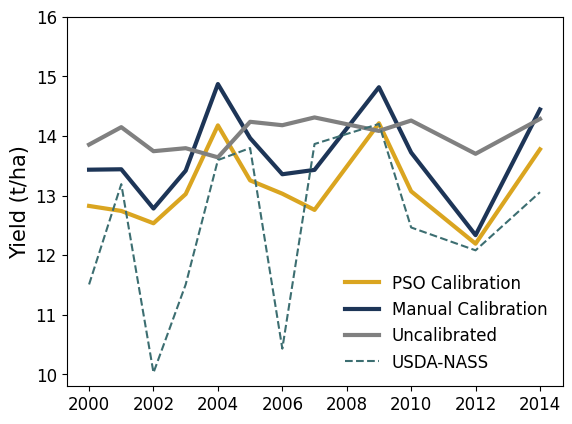

In [275]:
#model_comp = model_comp[model_comp['Year'] != 2009]
# comparison - time series plot
irrig_colors = ['#FFA500', '#8abbdb', '#69a6d0', '#4892c6', '#367bac', '#356384', '#344b5b']

plt.style.use('default')
plt.plot(model_comp['Year'], model_comp['Auto Calib Yield (t/ha)'],  label='PSO Calibration', color = 'goldenrod', linewidth=3)
plt.plot(model_comp['Year'], model_comp['Manual Calib Yield (t/ha)'],  label='Manual Calibration', color = '#1d3557', linewidth=3)

plt.plot(model_comp['Year'], model_comp['Uncalib Yield (t/ha)'],  label='Uncalibrated', color = 'grey', linewidth=3)
plt.plot(model_comp['Year'], model_comp['YieldUSDA'],  label='USDA-NASS', color = '#3c6e71', linestyle='dashed')
plt.ylabel('Yield (t/ha)', fontsize=15)
plt.legend(loc='lower right', fontsize=12, frameon=False)
plt.ylim(9.8, 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/home/jupyter-wndlovu/eggs/results/visuals/yieldmodelcal_pso_nostress_may10.png', format='png', dpi=600)


In [ ]:
irrig_colors = ['#FFA500', '#8abbdb', '#69a6d0', '#4892c6', '#367bac', '#356384', '#344b5b']

plt.style.use('default')
plt.plot(model_comp['Year'], model_comp['Calib Irrigation (mm)'],  label='Calibrated AqC', color = 'goldenrod', linewidth=3)
plt.plot(model_comp['Year'], model_comp['Uncalib Irrigation (mm)'],  label='Uncalibrated AqC', color = 'grey', linewidth=3)
plt.plot(model_comp['Year'], model_comp['irrig_depth'],  label='USDA-NASS', color = '#2e8b57', linestyle='dashed')
plt.ylabel('Yield (t/ha)', fontsize=15)
plt.legend(loc='lower right', fontsize=12, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [19]:
# 1:1 plot
plt.scatter(model_comp['YieldUSDA'], model_comp['Calib Yield (t/ha)'],  label='Calibrated AqC', color = 'goldenrod', edgecolors = 'black', s = 50)
plt.scatter(model_comp['YieldUSDA'], model_comp['Uncalib Yield (t/ha)'],  label='Uncalibrated AqC', color = 'grey', edgecolors = 'black', s=50)
plt.plot([10,15],[10,15], color = 'black')
plt.legend(loc='lower right', fontsize=12, frameon=False)
plt.ylabel('AquaCrop Yield (t/ha)', fontsize=15)
plt.xlabel('USDA-NASS (t/ha)', fontsize=15)
plt.legend(loc='lower right', fontsize=12, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('results/visuals/yieldmodelcal_40SMT_11.png', format='png', dpi=600)

NameError: name 'model_comp' is not defined

In [135]:
# calculate fit params
from statistics import mean
from sklearn.metrics import r2_score 

def model_fit(y, yhat):
    mae = metrics.mean_absolute_error(y, yhat)
    mse = metrics.mean_squared_error(y, yhat)
    rmse = np.sqrt(mse) # or mse**(0.5) 
    model = LinearRegression().fit(y, yhat)
    r2 = model.score(y, yhat)
  
    #r2 = r2_score(y, yhat)
    d_num = ((yhat.squeeze() - y.squeeze())**2).sum()
    d_denom1 = np.abs(yhat.squeeze()-y.squeeze().mean())
    d_denom2 = np.abs(y.squeeze()-y.squeeze().mean())
    d = 1 - (d_num/((d_denom1+d_denom2)**2).sum())
    pe = ((yhat.squeeze() - y.squeeze())/y.squeeze()) * 100
    sum_stats = {'var_name': ['mae', 'rmse', 'r2', 'd'],
                 'value': [mae, rmse, r2, d]}
                
    sum_stats_df = pd.DataFrame(sum_stats)
    
    return(sum_stats_df)

#model_comp = model_comp[model_comp['Year'] != 2009]

uncalib_yield = model_fit(model_comp[['YieldUSDA']], model_comp[['Uncalib Yield (t/ha)']])
uncalib_yield = uncalib_yield.rename(columns={"value": "uncalibrated"})

calib_yield = model_fit(model_comp[['YieldUSDA']], model_comp[['Calib Yield (t/ha)']])
calib_yield = calib_yield.rename(columns={"value": "calibrated"})

yield_fit = uncalib_yield.merge(calib_yield,on='var_name')


In [136]:
yield_fit

,var_name,uncalibrated,calibrated
0,mae,1.551917,1.005556
1,rmse,1.958434,1.291800
2,r2,0.224544,0.298810
3,d,0.491308,0.595138
